<a href="https://colab.research.google.com/github/AnonymousUser08/EMA/blob/main/PPMI-Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying PPMI DAT scans into Parkinson's Disease and Healthy Controls

Licensed under [this](LICENSE) license.

This notebook shows how we performed the experiment to fine-tune the Inception V3 classifier to distinguish patients with and without signs of Parkinson's disease.

The notebook is optimized to work with Google Colab. It hides all code by default so that you can run it sequentially from top to bottom. If you want to see the implementation, just double-click into any cell, and it will open in a side-by-side view.

This code is part of the publication
> Publication reference and [link](dummy-link-not-working-yet) to be inserted after publishing.

The data are a derivative of the DAT scans available from the [PPMI repository](https://www.ppmi-info.org/access-data-specimens/download-data/). They were processed to represent the central 5 slices of the putamen in one slice by averaging them. For details, please refer to the paper.

The data was then split randomly into a training and a validation set. As we tested the performance on an independant test set drawn from clinical routine which cannot be published, this notebook does not contain testing of the trained classifier.

The data as used in the publication can be downloaded here:

If you want to run the notebook from Google Colab, put the data into your Google Drive, and adapt the path below in the respective cell.

In [1]:
#@title Download and unzip the data. {display-mode:'form'}
#@markdown The data resides in the GitHub repository. For Hosted Runtime users, it is temporarily downloaded to the runtime's location.

from urllib.request import urlopen
from zipfile import ZipFile
zipurl = 'https://github.com/mtwenzel/parkinson-classification/raw/master/data/PPMI-classification.zip'
zipresp = urlopen(zipurl)
tempzip = open("PPMI-classification.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
print("download complete, extracting...")

zf = ZipFile("PPMI-classification.zip")
zf.extractall(path = 'data/')
zf.close()
print("... done")

download complete, extracting...
... done


In [2]:
#@title Check GPU availability {display-mode: 'form'}
#@markdown If you don't see a GPU in Colab, activate it by selecting *Runtime -> Change Runtime Type* in the menu.

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print('')
print('Detailed information:')
print('---------------------')
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Found GPU at: /device:GPU:0

Detailed information:
---------------------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14570126206255903728
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7423396944645973300
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
#@title Imports. {display-mode:'form'}
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling2D,Flatten,concatenate,BatchNormalization, Dropout
from tensorflow.keras.applications import InceptionV3,DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Visualize the Train/Val loss
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#@title Set the data generators. {display-mode:'form', run: "auto"}
#@markdown Data augmentation choices. Cell runs automatically if anything is changed.
shear_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
zoom_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
width_shift_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
height_shift_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
rotation_range = 10 #@param {type:"slider", min:0, max:90, step:5}
horizontal_flip = True #@param {type:"boolean"}
vertical_flip = False #@param {type:"boolean"}
#@markdown Data source (No need to change if the download succeeded.)
data_directory = '/content/data/PPMI-classification/' #@param ['z:/Data/Parkinson_DATScans UKE/full_ppmi_data/png/', '/content/drive/My Drive/MEVIS/Data/PPMI-classification/'] {allow-input: true}

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=shear_range,
    zoom_range=zoom_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    rotation_range=rotation_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip)

train_generator = train_datagen.flow_from_directory(os.path.join(data_directory, 'all_2d_train'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True)

# Data Generator for validation without data augmentation!
val_datagen   = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(os.path.join(data_directory, 'all_2d_val'), # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 1097 images belonging to 2 classes.
Found 193 images belonging to 2 classes.


In [14]:
#@title Set up the pretrained model, and add dense layers. {display-mode:'form', run: "auto"}
#@markdown Set up the trainable dense layers. Further options include BatchNorm (provides regularization), DropOut (also, for normalization, but should not be used together with BatchNorm), and GlobalAveragePooling as an alternative to simple flattening. Did not work well in our experiments.  Cell runs automatically if anything is changed.
first_dense_layer_neurons  = 1024 #@param {type:"integer"}
second_dense_layer_neurons = 256 #@param {type:"integer"}
use_global_average_pooling = False #@param {type:"boolean"}
use_batch_norm             = True #@param {type:"boolean"}
use_drop_out               = True  #@param {type:"boolean"}
pretrained_model           = 'DenseNet 121' #@param ["Inception V3", "DenseNet 121"]
optimizer                  = 'adam' #@param ['adam', 'adagrad', 'adadelta', 'sgd'] {allow-input: true}

if pretrained_model == 'Inception V3':
    base_model=InceptionV3(weights='imagenet',include_top=False, input_shape=(109,91,3))
else:
    base_model=DenseNet121(weights='imagenet',include_top=False, input_shape=(109,91,3))

x=base_model.output

if use_global_average_pooling == True:
    x=GlobalAveragePooling2D()(x)
else:
    x=Flatten()(x)

if use_batch_norm:
    x = BatchNormalization()(x)
if use_drop_out:
    x = Dropout(rate=0.5)(x)
x = Dense(first_dense_layer_neurons,activation='relu')(x)

if use_batch_norm:
    x = BatchNormalization()(x)
if use_drop_out:
    x = Dropout(rate=0.5)(x)
x = Dense(second_dense_layer_neurons,activation='relu')(x)

if use_batch_norm:
    x = BatchNormalization()(x)
if use_drop_out:
    x = Dropout(rate=0.5)(x)
preds = Dense(2,activation='softmax')(x) # final layer with softmax activation

model = Model(inputs=base_model.input,outputs=preds)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## First pass: train added dense layers
Set up the trainable parameters.

First train only the top layers (which were randomly initialized), i.e. freeze all convolutional InceptionV3 layers

In [17]:
#@title Set up trainable parameters {display-mode:'form'}
# @title Set up trainable parameters {display-mode:'form'}

for layer in base_model.layers:
    layer.trainable = False

if optimizer in ['adam', 'adagrad', 'adadelta', 'sgd']:  # standard settings
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # categorical crossentropy would also do...
else:
    from tensorflow.keras.optimizers import SGD
    model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Calculate trainable and non-trainable parameters
trainable_count = int(np.sum([K.count_params(p) for p in model.trainable_weights]))
non_trainable_count = int(np.sum([K.count_params(p) for p in model.non_trainable_weights]))

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))


Total params: 13,622,594
Trainable params: 6,570,242
Non-trainable params: 7,052,352


In [19]:
#@title Run training {display-mode:'form'}
# @title Run training {display-mode:'form'}

history = model.fit(
    x=train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=100,  # Originally, 500 epochs!
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7569 - loss: 0.6390 - val_accuracy: 0.6198 - val_loss: 0.7538
Epoch 2/100
 1/17 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9219 - loss: 0.3199

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 351ms/step - accuracy: 0.9219 - loss: 0.3199 - val_accuracy: 1.0000 - val_loss: 0.5763
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - accuracy: 0.9008 - loss: 0.2896 - val_accuracy: 0.8021 - val_loss: 0.4124
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9844 - loss: 0.1047 - val_accuracy: 1.0000 - val_loss: 0.0185
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9326 - loss: 0.2331 - val_accuracy: 0.9010 - val_loss: 0.2654
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.1568 - val_accuracy: 1.0000 - val_loss: 0.0682
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9288 - loss: 0.2228 - val_accuracy: 0.9479 - val_loss: 0.2006
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.1761 - val_accuracy: 1.0000 - val_loss: 0.0512
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.9279 - loss: 0.2118 - val_accuracy: 0.9427 - val

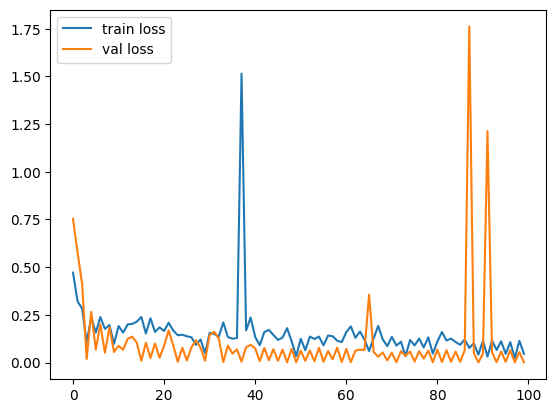

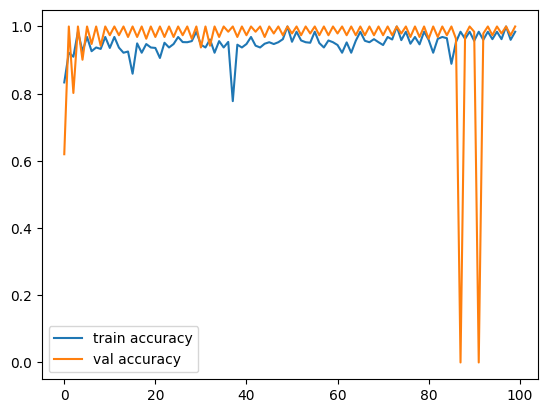

In [26]:
#@title Plot train and validation loss/accuracy {display-mode:'form'}

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Depending on the version of TF/Keras, the metric is either stored as 'acc' or 'accuracy'. This is not checked here.
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

## Fine-tune last convolutional layers

The top layers should have converged, and it would be good practice to fine-tune the top convolutional layers.

Print the layers with indices.

We chose to fine-tune the top 2 inception blocks, i.e. we will freeze the first 249 layers and unfreeze the rest. Afterwards, the model needs to be recompiled.

Note that this will not change the trained parameters.


In [28]:
# Freezing some layers and unfreezing others
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# Correct usage of learning_rate in SGD optimizer
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Calculate trainable and non-trainable parameters
trainable_count = int(
    np.sum([K.count_params(p) for p in model.trainable_weights]))
non_trainable_count = int(
    np.sum([K.count_params(p) for p in model.non_trainable_weights]))

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

0 input_layer_7
1 zero_padding2d
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 zero_padding2d_1
6 pool1
7 conv2_block1_0_bn
8 conv2_block1_0_relu
9 conv2_block1_1_conv
10 conv2_block1_1_bn
11 conv2_block1_1_relu
12 conv2_block1_2_conv
13 conv2_block1_concat
14 conv2_block2_0_bn
15 conv2_block2_0_relu
16 conv2_block2_1_conv
17 conv2_block2_1_bn
18 conv2_block2_1_relu
19 conv2_block2_2_conv
20 conv2_block2_concat
21 conv2_block3_0_bn
22 conv2_block3_0_relu
23 conv2_block3_1_conv
24 conv2_block3_1_bn
25 conv2_block3_1_relu
26 conv2_block3_2_conv
27 conv2_block3_concat
28 conv2_block4_0_bn
29 conv2_block4_0_relu
30 conv2_block4_1_conv
31 conv2_block4_1_bn
32 conv2_block4_1_relu
33 conv2_block4_2_conv
34 conv2_block4_concat
35 conv2_block5_0_bn
36 conv2_block5_0_relu
37 conv2_block5_1_conv
38 conv2_block5_1_bn
39 conv2_block5_1_relu
40 conv2_block5_2_conv
41 conv2_block5_concat
42 conv2_block6_0_bn
43 conv2_block6_0_relu
44 conv2_block6_1_conv
45 conv2_block6_1_bn
46 conv2_block6_1_relu
47 conv2_b

In [29]:
#@title Run training {display-mode:'form'}

history_finetune = model.fit(train_generator,
                              steps_per_epoch=train_generator.n//train_generator.batch_size,
                              epochs=100,
                             validation_data=val_generator,
                             validation_steps=val_generator.n//val_generator.batch_size)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.8806 - loss: 0.4044 - val_accuracy: 0.9792 - val_loss: 0.0425
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.9375 - loss: 0.1676 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.9207 - loss: 0.2427 - val_accuracy: 0.9896 - val_loss: 0.0433
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9531 - loss: 0.0848 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.9352 - loss: 0.1923 - val_accuracy: 0.9896 - val_loss: 0.0456
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9375 - loss: 0.2736 - val_accuracy: 1.0000 - val_loss: 8.3769e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - accuracy: 0.9362 - loss: 0.1618 - val_accuracy: 0.9896 - val_loss: 0.0475
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9531 - loss: 0.0950 - val_accura

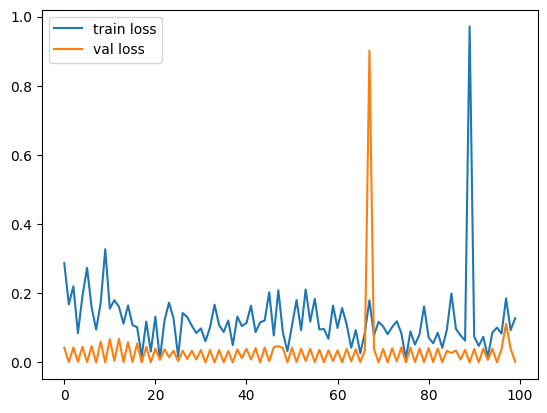

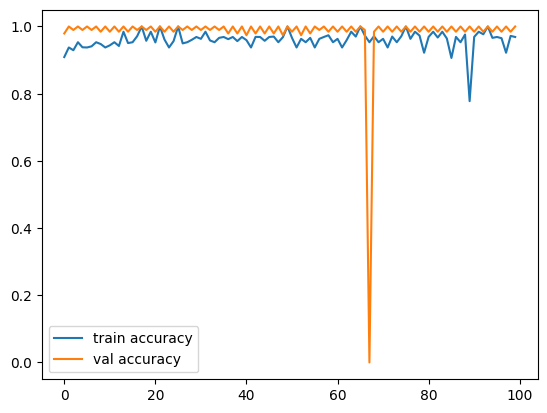

In [31]:
#@title Plot train and validation loss/accuracy {display-mode:'form'}
plt.plot(history_finetune.history['loss'], label='train loss')
plt.plot(history_finetune.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history_finetune.history['accuracy'], label='train accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()